<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> Procesamiento de Lenguaje Natural 
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Laboratorio 4:</strong> Modelos de Lenguaje con N-gramas, Espacidad y Suavizado</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autor:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
      </ul>
    </td>
  </tr>
</table>

In [203]:
import nltk
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [204]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk import ngrams, ConditionalFreqDist
from nltk.lm import KneserNeyInterpolated
from nltk.corpus import cess_esp
from nltk.util import ngrams
import pandas as pd
import random
import re

In [205]:
# Load the CESS-ESP corpus
corpus = cess_esp.sents()

# Preprocesamiento del corpus

Para que los modelos funcionen óptimamente, se procede a realizar la estandarización del corpus proporcionado. El primer elemento detectado es que el corpus utiliza marcas para identificar patrones sintácticos. Por ejemplo -Fpa-, -Fpt- y *0*, pero como el objetivo del laboratorio es generar texto fluido con n-gramas, se procede a filtrarlos.

In [206]:
def removeSpecialTags(sentences):
    """
    Elimina tokens como -Fpa-, -Fpt- (rodeados por guiones)
    y tokens como *0*, *1* (placeholders de anotación sintáctica)
    en el corpus cess_esp.
    """
    cleaned = []
    for sentence in sentences:
        cleaned_sentence = [
            word for word in sentence
            if not (word.startswith('-') and word.endswith('-'))  # -Fpa-, -Fpt-
            and not re.fullmatch(r"\*\d+\*", word)                # *0*, *1*, etc.
        ]
        cleaned.append(cleaned_sentence)
    return cleaned

comments = removeSpecialTags(corpus)

In [207]:
comments = [' '.join(sent) for sent in comments]
comments[:10]

['El grupo estatal Electricité_de_France EDF anunció hoy , jueves , la compra del 51_por_ciento de la empresa mexicana Electricidad_Águila_de_Altamira EAA , creada por el japonés Mitsubishi_Corporation para poner_en_marcha una central de gas de 495 megavatios .',
 'Una portavoz de EDF explicó a EFE que el proyecto para la construcción de Altamira_2 , al norte de Tampico , prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002 .',
 'La electricidad producida pasará a la red eléctrica pública de México en_virtud_de un acuerdo de venta de energía de EAA con la Comisión_Federal_de_Electricidad CFE por una duración de 25 años .',
 'EDF , que no quiso revelar cuánto pagó por su participación mayoritaria en EAA , intervendrá como asistente en la construcción de Altamira_2 y , posteriormente , se encargará de explotarla como principal accionista .',
 'EDF y Mitsubishi participaron en 1998 en la licitación d

Se buscar analizar el efecto de la estandarización para identificar si existen apariciones de nuevas palabras con más repeticiones o simplemente, aumenta el número de las que actualmente se encuentran como más frecuentes. Para esto, se mostraran las 8 palabras más frecuentes antes del proceso y después del mismo. 

In [208]:
comments = [comment.strip() for comment in comments if comment.strip()]

def top_n_words(comments, n=8):
    from collections import Counter
    words = [word for comment in comments for word in comment.split()]
    return Counter(words).most_common(n)

print("Top 8 common words:")
print(top_n_words(comments))

Top 8 common words:
[(',', 11420), ('de', 10234), ('la', 6412), ('.', 5866), ('que', 5552), ('el', 5199), ('en', 4340), ('y', 4235)]


Para verificar si será necesario aplicar la transformación de mayusculas a mínusculas, se desarrolla una función que permite observar si una palabra tiene una equivalente en con algún caracter en mayúscula o minúscula en el corpus.

In [209]:
def encontrar_variaciones_de_casing(comments, max_resultados=3):
    formas_por_palabra = {}
    resultados_mostrados = 0

    for comment in comments:
        for word in comment.split():
            base = word.lower()
            if base not in formas_por_palabra:
                formas_por_palabra[base] = set()
            formas_por_palabra[base].add(word)

    for base, formas in formas_por_palabra.items():
        if len(formas) > 1:
            print(f"Variantes de '{base}': {formas}")
            resultados_mostrados += 1
            if resultados_mostrados >= max_resultados:
                break


print("Words with case variations:")
encontrar_variaciones_de_casing(comments)

Words with case variations:
Variantes de 'el': {'EL', 'el', 'El'}
Variantes de 'grupo': {'Grupo', 'grupo'}
Variantes de 'anunció': {'Anunció', 'anunció'}


Observamos que sí existen casos con variantes mayusculas y minusculas, por lo que sí se considera necesaria su aplicación. Además, se procede a analizar si ocurre lo mismo pero con signos de puntuación.

In [210]:
def encontrar_variaciones_de_puntuacion(comments, max_resultados=3):
    formas_por_palabra = {}
    resultados_mostrados = 0
    signos = ".!?,;:()\"'¿¡"

    for comment in comments:
        for word in comment.split():
            base = word.strip(signos)
            if base not in formas_por_palabra:
                formas_por_palabra[base] = set()
            formas_por_palabra[base].add(word)

    for base, formas in formas_por_palabra.items():
        if len(formas) > 1:
            print(f"Variantes de puntuación para '{base}': {formas}")
            resultados_mostrados += 1
            if resultados_mostrados >= max_resultados:
                break

print("Words with punctuation variations:")
encontrar_variaciones_de_puntuacion(comments)

Words with punctuation variations:
Variantes de puntuación para '': {'!', '¿', '...', '¡', "'", '?', '.', '"', ':', ';', ','}
Variantes de puntuación para 'PP': {'PP', 'PP.'}
Variantes de puntuación para '2': {'2', '2.'}


De esta forma identificamos que también se producen ocurrencias, por lo que se aplica el procedimiento de eliminación de puntuación

In [211]:
def erasePunctuation(comments):
    return [re.sub(r'[^\w\s]', '', line) for line in comments]

Se procede con la estandarización y se evalua el resultado.

In [212]:
comments = [comment.lower() for comment in comments]
comments = erasePunctuation(comments)
print("Top 8 common words after standardization:")
print(top_n_words(comments))  

Top 8 common words after standardization:
[('de', 10286), ('la', 6925), ('el', 6013), ('que', 5570), ('en', 4643), ('y', 4349), ('los', 3189), ('a', 3020)]


Se puede apreciar que existe un aumento en la frecuencia de algunas palabras, por lo tanto, la estandarización es efectiva. 

In [213]:
comments[:10]

['el grupo estatal electricité_de_france edf anunció hoy  jueves  la compra del 51_por_ciento de la empresa mexicana electricidad_águila_de_altamira eaa  creada por el japonés mitsubishi_corporation para poner_en_marcha una central de gas de 495 megavatios ',
 'una portavoz de edf explicó a efe que el proyecto para la construcción de altamira_2  al norte de tampico  prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002 ',
 'la electricidad producida pasará a la red eléctrica pública de méxico en_virtud_de un acuerdo de venta de energía de eaa con la comisión_federal_de_electricidad cfe por una duración de 25 años ',
 'edf  que no quiso revelar cuánto pagó por su participación mayoritaria en eaa  intervendrá como asistente en la construcción de altamira_2 y  posteriormente  se encargará de explotarla como principal accionista ',
 'edf y mitsubishi participaron en 1998 en la licitación de licencias p

Finalmente se identifica que existen secuencias de 2 o más espacios en blanco en la separación de algunas palabras, para evitar obtener bigramas incorrectos o que en algun punto de la estandarización afecten, se procede a normalizarlos.

In [214]:
def normalizeSpaces(lines):
    return [re.sub(r'\s+', ' ', line).strip() for line in lines]

In [215]:
comments = normalizeSpaces(comments)
comments[:10]

['el grupo estatal electricité_de_france edf anunció hoy jueves la compra del 51_por_ciento de la empresa mexicana electricidad_águila_de_altamira eaa creada por el japonés mitsubishi_corporation para poner_en_marcha una central de gas de 495 megavatios',
 'una portavoz de edf explicó a efe que el proyecto para la construcción de altamira_2 al norte de tampico prevé la utilización de gas natural como combustible principal en una central de ciclo combinado que debe empezar a funcionar en mayo_del_2002',
 'la electricidad producida pasará a la red eléctrica pública de méxico en_virtud_de un acuerdo de venta de energía de eaa con la comisión_federal_de_electricidad cfe por una duración de 25 años',
 'edf que no quiso revelar cuánto pagó por su participación mayoritaria en eaa intervendrá como asistente en la construcción de altamira_2 y posteriormente se encargará de explotarla como principal accionista',
 'edf y mitsubishi participaron en 1998 en la licitación de licencias para construir

De esta forma se procede a almacenar el corpus estandarizado.

In [216]:
with open("corpus.txt", "w", encoding="utf-8") as file:
    for comment in comments:
        file.write(comment + "\n")

## Construcción de modelos de n-gramas

Los modelos basados en bigramas requieren de una tokenización de los elementos para luego ser procesados mediante la formula condicional P(wn | wn-1, ... , wn-k+1) usando frecuencias relativas.

Con ayuda de nltk se construye un modelo de conteo condicional que permite calcular por cada palabra wn, cuántas veces aparece wn-1 después de la misma. Lo cual permite realizar el calculo de las probabilidades condicionales contando el total de ocurrencias por cada wn, usandolo como denominador de la frecuencia mencionada anteriormente.

Básicamente, se construyen los modelos en base a la siguiente fórmula:

\[
P(w_n \mid w_{n-1}, \dots, w_{n-k+1}) = \frac{C(w_{n-k+1}, \dots, w_n)}{C(w_{n-k+1}, \dots, w_{n-1})}
\]

donde \(k = 1, 2, 3\)


In [217]:
# Carga y tokenización del corpus estandarizado
with open("corpus.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

tokens = []
for line in lines:
    words = line.strip().split()
    tokens.extend(words)

tokens[:10]

['el',
 'grupo',
 'estatal',
 'electricité_de_france',
 'edf',
 'anunció',
 'hoy',
 'jueves',
 'la',
 'compra']

In [218]:
def trainNgramModel(comments, n):
    tokens = []
    for sentence in comments:
        tokens.extend(sentence.strip().split())

    ngram_list = list(ngrams(tokens, n))
    cfd = ConditionalFreqDist()

    for ng in ngram_list:
        context = () if n == 1 else tuple(ng[:-1])
        word = ng[0] if n == 1 else ng[-1]
        cfd[context][word] += 1

    model = {}
    for context in cfd:
        model[context] = {
            '__total__': cfd[context].N()
        }
        for word in cfd[context]:
            model[context][word] = cfd[context][word]

    vocab = set(tokens)
    return model, len(vocab)

In [219]:
bigramsProbability = []
n = [1, 2, 3]
for n_size in n:
    bigramProbability, vocabSizeC = trainNgramModel(comments, n_size)
    bigramsProbability.append(bigramProbability)

## Análisis de espacidad

Aunque en el ejercicio anterior se construyeron modelos de n-gramas sobre todo el corpus, para este análisis de espacidad es necesario separar una parte del corpus como conjunto de prueba. Esto permite evaluar cuántos n-gramas nuevos aparecen que no fueron observados en los datos de entrenamiento, lo cual es esencial para entender las limitaciones de los modelos. La separación se realizará con 75% entrenamiento y 25% prueba.

In [220]:
splitIndex = int(len(comments) * 0.75)
train_comments = comments[:splitIndex]
test_comments = comments[splitIndex:]

In [221]:
bigramsProbability = []
for n_size in n:
    bigramProbability, vocabSizeC = trainNgramModel(train_comments, n_size)
    bigramsProbability.append(bigramProbability)

In [222]:
def getNgrams(comments, n):
    tokens = []
    for sentence in comments:
        tokens.extend(sentence.strip().split())
    return list(ngrams(tokens, n))

In [223]:
def calculateSparsity(model, test_comments, n):
    test_ngrams = getNgrams(test_comments, n)
    total = len(test_ngrams)
    missing = 0

    for ng in test_ngrams:
        context = () if n == 1 else tuple(ng[:-1])
        word = ng[0] if n == 1 else ng[-1]

        if context not in model or word not in model[context]:
            missing += 1

    return (missing / total) * 100

In [224]:
for i, n_size in enumerate(n):
    model = bigramsProbability[i]
    sparsity = calculateSparsity(model, test_comments, n_size)
    print(f"Espacidad para n={n_size}: {sparsity:.2f}% de n-gramas no vistos")

Espacidad para n=1: 16.26% de n-gramas no vistos
Espacidad para n=2: 62.92% de n-gramas no vistos
Espacidad para n=3: 92.60% de n-gramas no vistos


Se infiere con esto que a mayor valor de n, mayor espacidad: el modelo necesita más combinaciones de palabras. De esta forma se limita la capacidad del modelo de generar texto o calcular la probabilidad para frases que son nuevas.

## Implementación de suavizado

El suavizado en modelos de n-gramas es una técnica que ajusta las probabilidades para que incluso los n-gramas no observados tengan una probabilidad distinta de cero.

### Suavizado de laplace

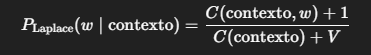

In [225]:
def laplaceSmoothedProbability(model, context, word, vocab_size):
    count = model.get(context, {}).get(word, 0)
    total = model.get(context, {}).get('__total__', 0)
    return (count + 1) / (total + vocab_size)

### Interpolación lineal

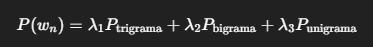

In [226]:
def interpolatedProbability(uni_model, bi_model, tri_model, context, word, vocab_size, lambdas=(0.4, 0.4, 0.2)):
    lambda3, lambda2, lambda1 = lambdas
    unigram = ()
    bigram = (context[-1],) if len(context) >= 1 else ()
    trigram = context if len(context) >= 2 else ()
    p1 = laplaceSmoothedProbability(uni_model, unigram, word, vocab_size)
    p2 = laplaceSmoothedProbability(bi_model, bigram, word, vocab_size)
    p3 = laplaceSmoothedProbability(tri_model, trigram, word, vocab_size)
    return lambda1 * p1 + lambda2 * p2 + lambda3 * p3

### Kneser-Ney

In [227]:
def trainKneserNeyModel(tokens, n):
    train_data, vocab = padded_everygram_pipeline(n, [tokens])
    model = KneserNeyInterpolated(order=n)
    model.fit(train_data, vocab)
    return model

Antes de realizar la implementación, los modelos se entrenarán en este caso con todo el corpus ya que en incisos posteriores lo que se busca evaluar es la perplejidad por lo que no existe la necesidad de hacer la separación en train y test.

In [228]:
bigramsProbability = []
bigramsVocabSize = []
n = [1, 2, 3]
for n_size in n:
    bigramProbability, vocabSizeC = trainNgramModel(comments, n_size)
    bigramsProbability.append(bigramProbability)
    bigramsVocabSize.append(vocabSizeC)

In [229]:
kneser_models = [trainKneserNeyModel(tokens, n) for n in [1, 2, 3]]

## Cálculo de perplejidad

In [230]:
def calculatePerplexityLaplace(tokens, model, vocab_size, n):
    import math
    N = len(tokens)
    if N < n:
        return float('inf')

    log_prob_sum = 0.0
    for i in range(N - n + 1):
        ngram = tuple(tokens[i:i + n])
        context = () if n == 1 else tuple(ngram[:-1])
        word = ngram[0] if n == 1 else ngram[-1]

        prob = laplaceSmoothedProbability(model, context, word, vocab_size)
        log_prob_sum += math.log(prob)

    return math.exp(-log_prob_sum / (N - n + 1))

In [231]:
def calculatePerplexityInterpolated(tokens, uni_model, bi_model, tri_model, vocab_size, lambdas=(0.2, 0.3, 0.5)):
    import math
    N = len(tokens)
    if N < 3:
        return float('inf')

    log_prob_sum = 0.0
    for i in range(N - 3 + 1):
        ngram = tuple(tokens[i:i + 3])
        context = ngram[:-1]
        word = ngram[-1]

        prob = interpolatedProbability(uni_model, bi_model, tri_model, context, word, vocab_size, lambdas)
        log_prob_sum += math.log(prob)

    return math.exp(-log_prob_sum / (N - 3 + 1))

In [232]:
sentence = "el proyecto de la construcción es grande y complejo"
sentence_tokens = sentence.strip().split()

# Tabla vacía
tabla_perplejidad = {
    "n": [],
    "Laplace": [],
    "Interpolación": [],
    "Kneser-Ney": []
}

for i, n_size in enumerate(n):
    tabla_perplejidad["n"].append(n_size)

    # === Laplace ===
    model_laplace = bigramsProbability[i]
    vocab_laplace = bigramsVocabSize[i]
    ppl_laplace = calculatePerplexityLaplace(sentence_tokens, model_laplace, vocab_laplace, n_size)
    tabla_perplejidad["Laplace"].append(round(ppl_laplace, 2))

    # === Interpolación (solo para n = 3) ===
    if n_size == 3:
        ppl_interp = calculatePerplexityInterpolated(
            sentence_tokens,
            bigramsProbability[0],
            bigramsProbability[1],
            bigramsProbability[2],
            vocab_laplace
        )
        tabla_perplejidad["Interpolación"].append(round(ppl_interp, 2))
    else:
        tabla_perplejidad["Interpolación"].append("—")

    # === Kneser-Ney usando model.perplexity() de nltk.lm ===
    if n_size == 1:
        tabla_perplejidad["Kneser-Ney"].append("—")
    else:
        test_ngrams = list(ngrams(sentence_tokens, n_size))
        ppl_kn = kneser_models[i].perplexity(test_ngrams)
        tabla_perplejidad["Kneser-Ney"].append(round(ppl_kn, 2))

# Mostrar la tabla
df_perplejidad = pd.DataFrame(tabla_perplejidad)
display(df_perplejidad)

,n,Laplace,Interpolación,Kneser-Ney
0,1,497.11,—,—
1,2,3454.97,—,307.78
2,3,14720.46,691.0,670.7


## Generación de texto

In [233]:
def generateTextLaplace(model, vocab, vocab_size, n, seed, length=15):
    generated = seed.strip().split()
    for _ in range(length):
        context = tuple(generated[-(n-1):]) if n > 1 else ()
        probs = {}
        for word in vocab:
            prob = laplaceSmoothedProbability(model, context, word, vocab_size)
            probs[word] = prob
        next_word = random.choices(list(probs.keys()), weights=probs.values())[0]
        generated.append(next_word)
    return ' '.join(generated)

In [237]:
def generateTextInterpolated(unigrams, bigrams, trigrams, vocab, n, seed, length):
    generated = seed.strip().split()

    for _ in range(length):
        # Asegura que el contexto tiene la longitud adecuada
        context = tuple(generated[-(n-1):]) if len(generated) >= n-1 else tuple(generated)
        
        probs = {}
        for word in vocab:
            prob = interpolatedProbability(
                unigrams, bigrams, trigrams,
                context,
                word,
                len(vocab)
            )
            probs[word] = prob

        # Selección ponderada
        next_word = random.choices(list(probs.keys()), weights=probs.values())[0]
        generated.append(next_word)

    return ' '.join(generated)


In [245]:
def generateTextKneserNey(model, n, seed, length=15):
    generated = seed.strip().split()
    context = tuple(generated[-(n-1):]) if n > 1 else ()

    # Usamos directamente .generate con num_words=length y el context inicial
    generated_words = list(model.generate(length, text_seed=context))

    # Unimos el seed original con las nuevas palabras generadas
    return ' '.join(generated + generated_words)

In [248]:
seed = "el"
length = 15

all_tokens = []
for sentence in comments:
    all_tokens.extend(sentence.strip().split())

vocabulario = set(all_tokens)

for i, n_size in enumerate(n):
    print(f"\n--- n = {n_size} ---")

    # Laplace
    print("Laplace:")
    print(generateTextLaplace(bigramsProbability[i], vocabulario, bigramsVocabSize[i], n_size, seed, length))

    # Interpolación (solo para n=3)
    if n_size == 3:
        print("\nInterpolación:")
        print(generateTextInterpolated(
            bigramsProbability[0],
            bigramsProbability[1],
            bigramsProbability[2],
            vocabulario,
            n_size,
            seed,
            length
        ))

    # Kneser-Ney
    if n_size >= 2:
        model = kneser_models[i]
        print("\nKneser-Ney:")
        print(generateTextKneserNey(model, n_size, seed, length))



--- n = 1 ---
Laplace:
el su sobre_todo cristal quede depor de los la él guatemaltecos particular europeo sur de la

--- n = 2 ---
Laplace:
el bienestar arg estuvo presiona consumo proyecta desdoro denunció tirarla obligados bateo girar rencor fuerza_armada 4b

Kneser-Ney:
el rey_juan_carlos se mostró convencido de ajuste de contratación ya_que puede criticar porque lo que sobre

--- n = 3 ---
Laplace:
el monetario abren rendimiento extraño 4p sentado tony_rominger tamaños kim_dae_jung mafiosa indeseados de_tarde_en_tarde entiende caballería utilitario

Interpolación:
el heroicidad especialistas almorzando ariete al_cabo_de remitir evitar caracolean castigada simpática trato objetivos ojo aplacar aún

Kneser-Ney:
el de su puesta en marcha de la tierra y han estado marcados por insultos personales


## Discusión final

Los resultados evidencian cómo las distintas técnicas de suavizado afectan significativamente la perplejidad del modelo. El suavizado de Laplace genera perplejidades excesivamente altas a medida que aumenta el valor de n, especialmente en n=3 donde supera los 14,000. Esto indica que este método no maneja adecuadamente la esparsidad en n-gramas a medida que n es mayor. En cambio, otras técnicas como la Interpolación (691.0) y Kneser-Ney (670.7) logran una mejor distribución de probabilidad, reduciendo considerablemente la perplejidad y reflejando un mejor rendimiento estadístico del modelo.

A medida que aumenta n, los modelos pueden considerar más contexto anterior, lo cual mejora la fluidez y coherencia del texto generado. Con n=1 (Laplace), el texto resulta desorganizado y con poca estructura. Para n=2, los modelos empiezan a generar frases parcialmente coherentes. Finalmente, con n=3, los textos generados mediante Interpolación y Kneser-Ney presentan oraciones más naturales y con una mejor conexión entre palabras. Esto sugiere que la capacidad de modelar el contexto largo, combinada con un suavizado efectivo, mejora sustancialmente la calidad del lenguaje generado.

La esparsidad tiene un impacto directo y severo en el rendimiento de los modelos. Cuando el corpus no contiene suficientes combinaciones posibles de palabras, los modelos sin un buen suavizado (como Laplace) asignan malas probabilidades, elevando la perplejidad y afectando la generación de texto. Modelos como Kneser-Ney son menos vulnerables a este problema, ya que estiman la probabilidad de un n-grama basándose también en cómo aparecen las palabras en otros contextos, permitiendo una mejor generalización incluso con datos escasos.